# Getting the data ready

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly as py
import plotly.express as px
from pandas import DataFrame
from sklearn import datasets

from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from prettytable import PrettyTable

pd.options.mode.chained_assignment = None 

#### Import the dataset

In [2]:
# Import dataset
games = pd.read_csv("xbox_video_games.csv", header=0, encoding="unicode_escape")
games

Pos                       Game    Year             Genre  \
0      1         Grand Theft Auto V  2014.0            Action   
1      2  Call of Duty: Black Ops 3  2015.0           Shooter   
2      3         Call of Duty: WWII  2017.0           Shooter   
3      4      Red Dead Redemption 2  2018.0  Action-Adventure   
4      5                  MineCraft  2014.0              Misc   
..   ...                        ...     ...               ...   
608  609                  Biomutant  2018.0            Action   
609  610                  Biomutant  2019.0            Action   
610  611                    de Blob  2017.0          Platform   
611  612    Outcast: Second Contact  2017.0         Adventure   
612  613                  Code Vein  2019.0            Action   

                      Publisher  North America  Europe  Japan  Rest of World  \
0                Rockstar Games           4.70    3.25   0.01           0.76   
1                    Activision           4.63    2.04   0.02           0.68   
2                    Activision           3.75    1.91   0.00           0.57   
3                Rockstar Games           3.76    1.47   0.00           0.54   
4             Microsoft Studios           3.23    1.71   0.00           0.49   
..                          ...            ...     ...    ...            ...   
608                  THQ Nordic           0.00    0.00   0.00           0.00   
609                  THQ Nordic           0.00    0.00   0.00           0.00   
610                  THQ Nordic           0.00    0.00   0.00           0.00   
611          Bigben Interactive           0.00    0.00   0.00           0.00   
612  Bandai Namco Entertainment           0.00    0.00   0.00           0.00   

     Global  
0      8.72  
1      7.37  
2      6.23  
3      5.77  
4      5.43  
..      ...  
608    0.00  
609    0.00  
610    0.00  
611    0.00  
612    0.00  

[613 rows x 10 columns]

#### Remove null values & format column names

In [3]:
# Remove null values
games.dropna(inplace=True)

# Format column names
games.rename(inplace=True, columns=str.lower)
games.rename(inplace=True, columns={"north america": "na_sales", "europe": "eu_sales", "japan": "jp_sales", "rest of world": "other_sales"})
games = games[['na_sales', 'eu_sales', 'other_sales']]
games

na_sales  eu_sales  other_sales
0        4.70      3.25         0.76
1        4.63      2.04         0.68
2        3.75      1.91         0.57
3        3.76      1.47         0.54
4        3.23      1.71         0.49
..        ...       ...          ...
608      0.00      0.00         0.00
609      0.00      0.00         0.00
610      0.00      0.00         0.00
611      0.00      0.00         0.00
612      0.00      0.00         0.00

[505 rows x 3 columns]

#### Check for outliers

In [4]:
fig = px.box(games, y='na_sales')
fig.show()

In [5]:
def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

def drop_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    outliers_dropped = outliers.dropna().reset_index()
    return outliers_dropped


In [6]:
# Remove outliers
games = games.drop(games[games['na_sales'] == 4.7].index)
games = games.drop(games[games['na_sales'] == 4.63].index)
games = games.drop(games[games['eu_sales'] == 3.25].index)
games.head()

na_sales  eu_sales  other_sales
2      3.75      1.91         0.57
3      3.76      1.47         0.54
4      3.23      1.71         0.49
5      3.25      1.49         0.48
6      3.37      1.26         0.48

# Clustering

#### Elbow plot to find good K value

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

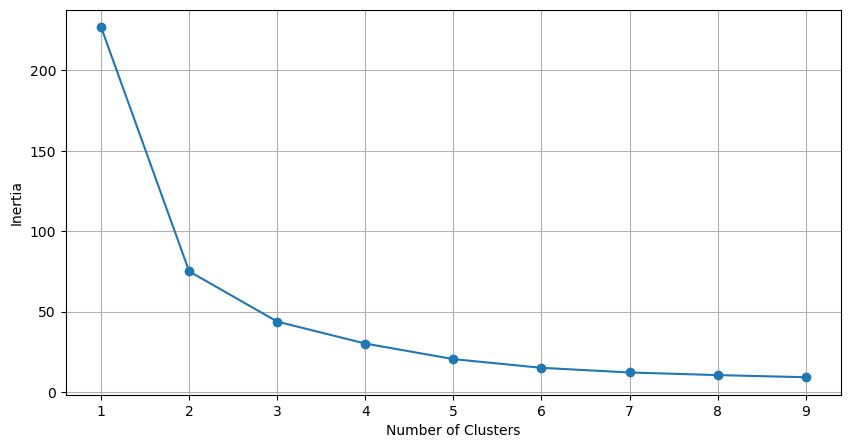

In [7]:
# Function to find K
df = games[['na_sales', 'eu_sales', 'other_sales']]

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    # Elbow plot
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

optimise_k_means(df, 10)

#### Perform clustering with different models

In [8]:
# K-means
kmeans = KMeans(n_clusters=7, n_init="auto", random_state=10)
df['kmeans'] = kmeans.fit_predict(df)

# DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=7).fit(df)
clustering.labels_
df['dbscan'] = clustering.labels_

# GMM
gmm = GaussianMixture(n_components=7)
gmm.fit(df)
df['gmm'] = gmm.predict(df)

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 2 The average silhouette_score is : 0.8149401068974257
For n_clusters = 3 The average silhouette_score is : 0.8505392275671754


C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 4 The average silhouette_score is : 0.8866491673728101
For n_clusters = 5 The average silhouette_score is : 0.9345505717225913


C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 6 The average silhouette_score is : 0.94470903039155
For n_clusters = 7 The average silhouette_score is : 0.9560859010764104


C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 8 The average silhouette_score is : 0.9553430822038151
For n_clusters = 9 The average silhouette_score is : 0.9420206509048442


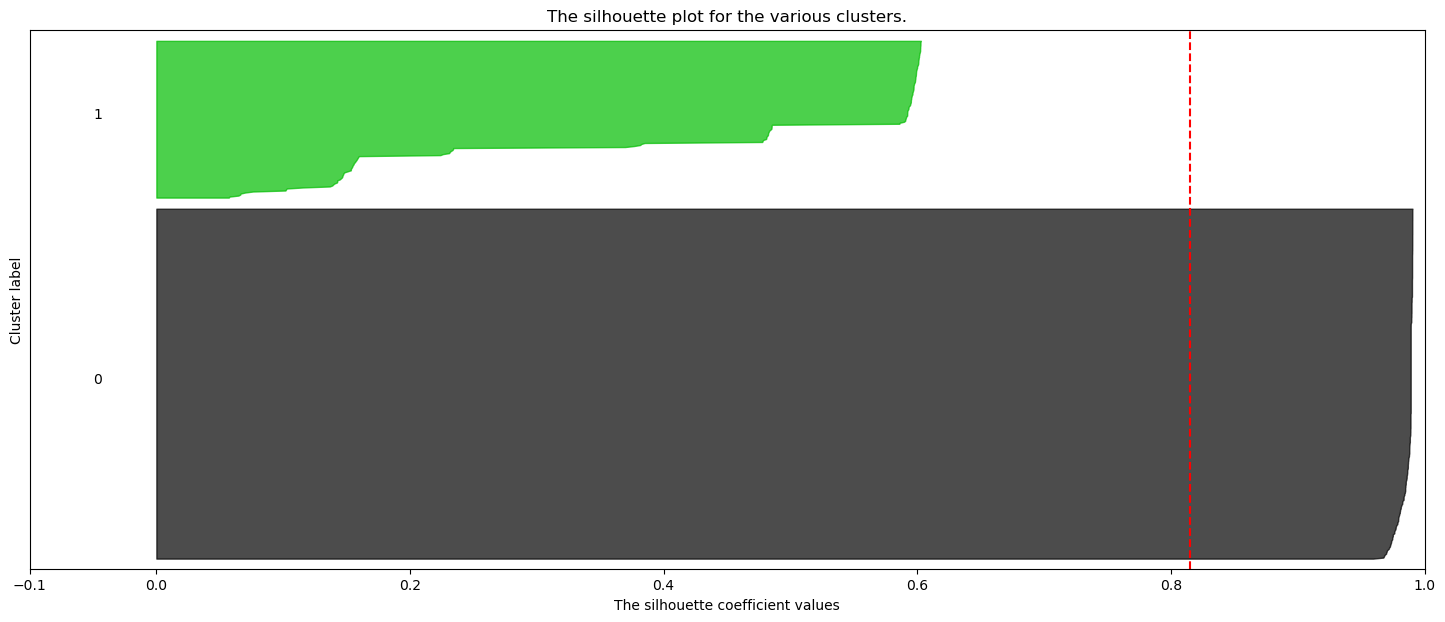

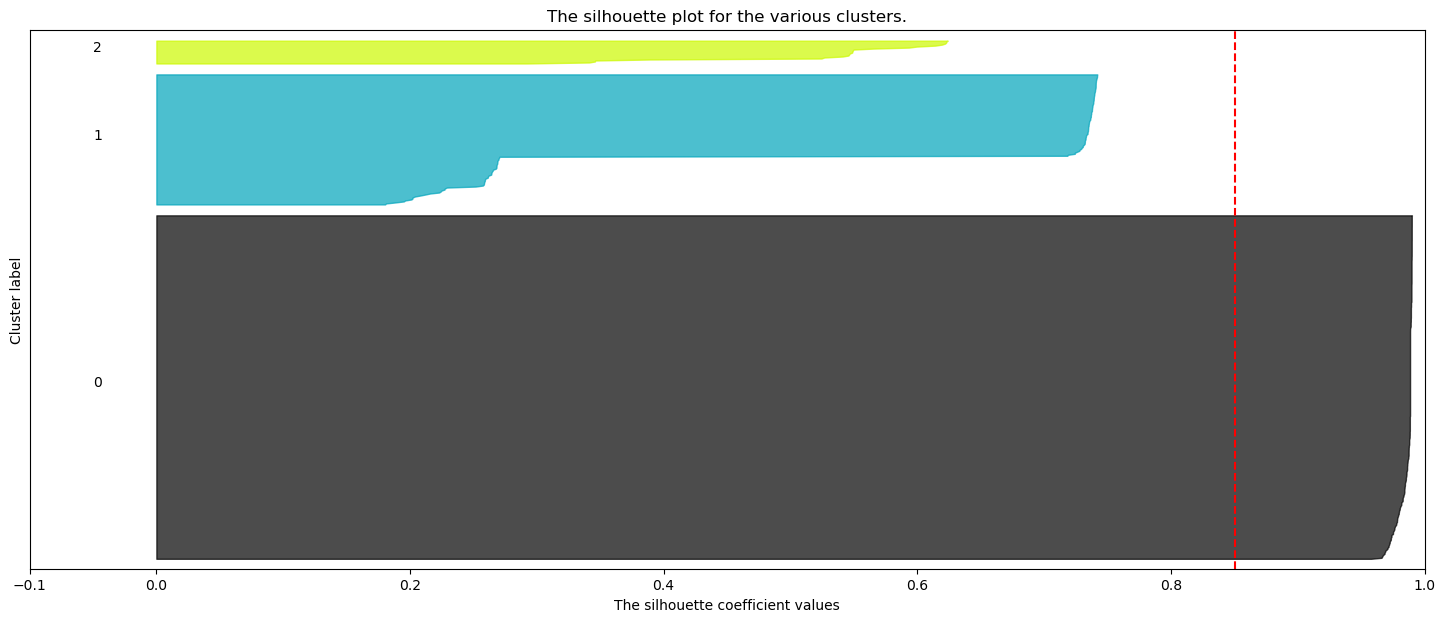

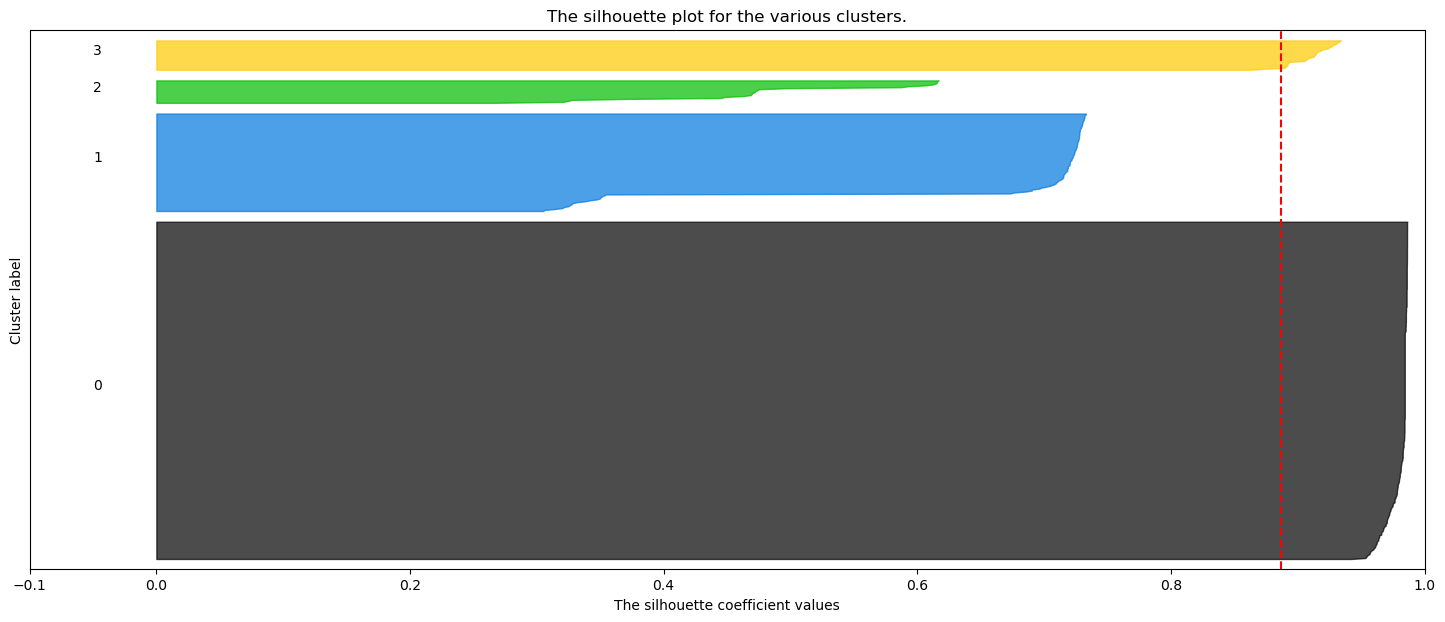

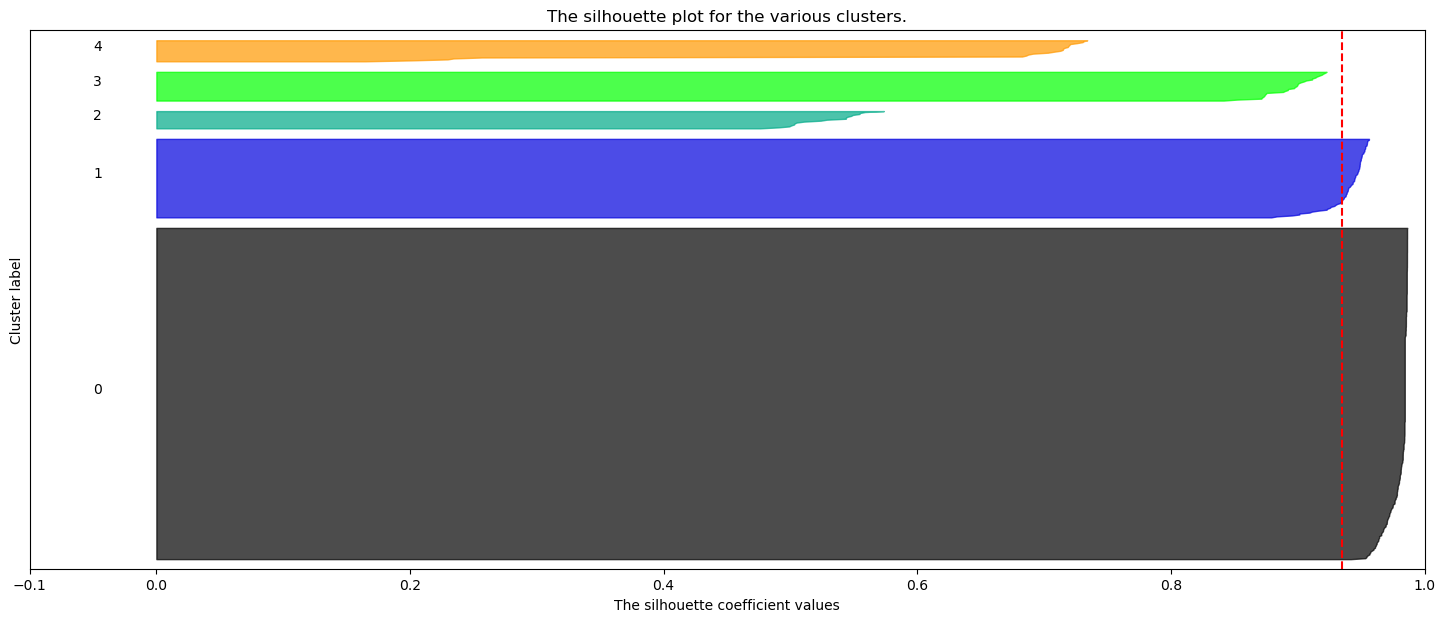

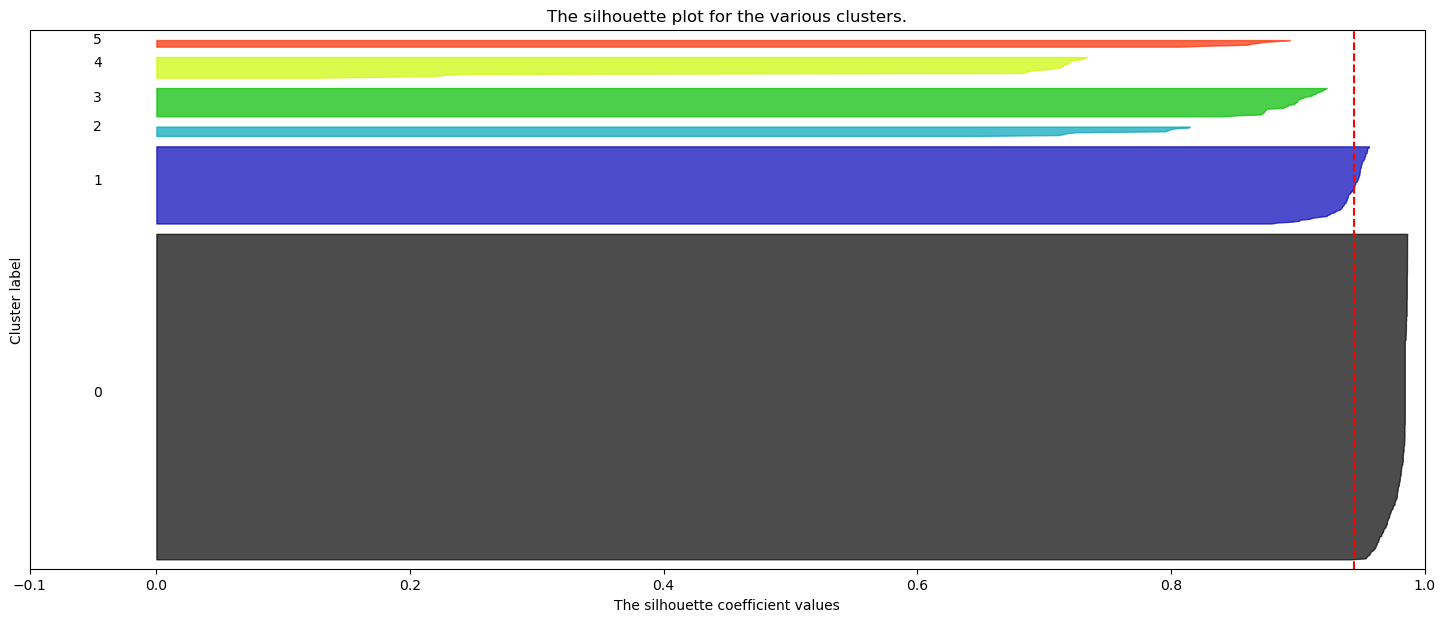

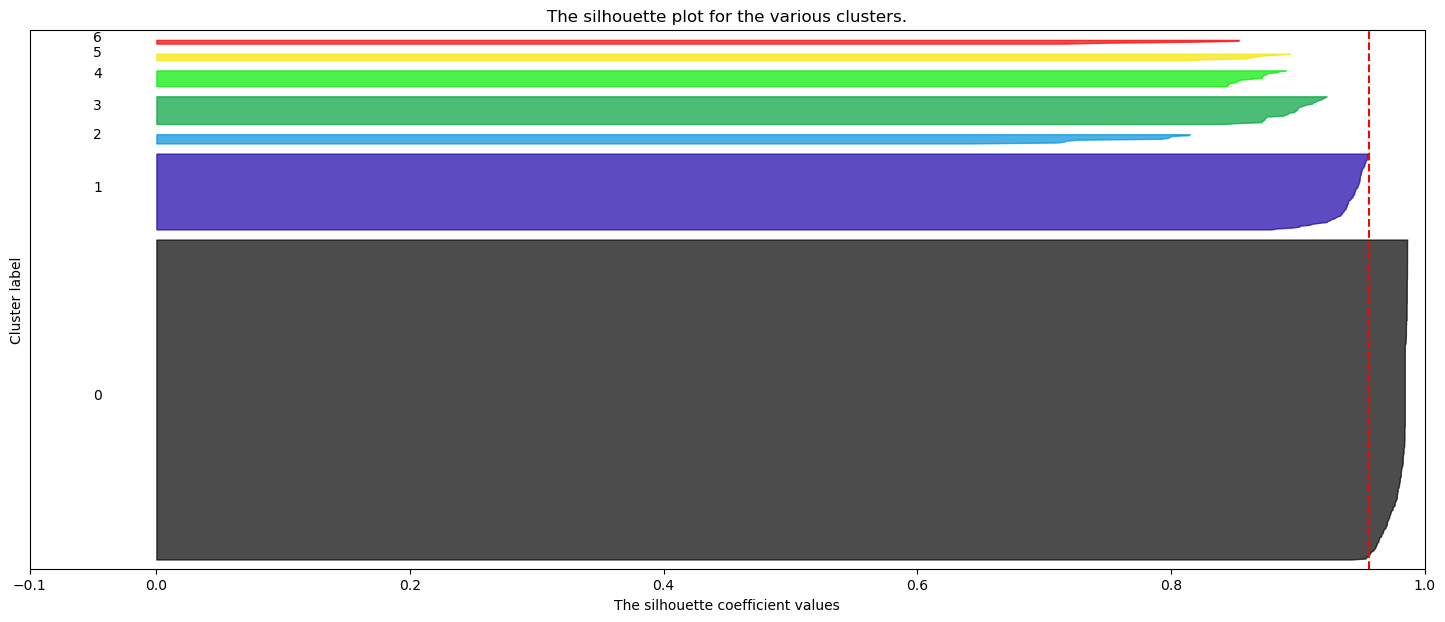

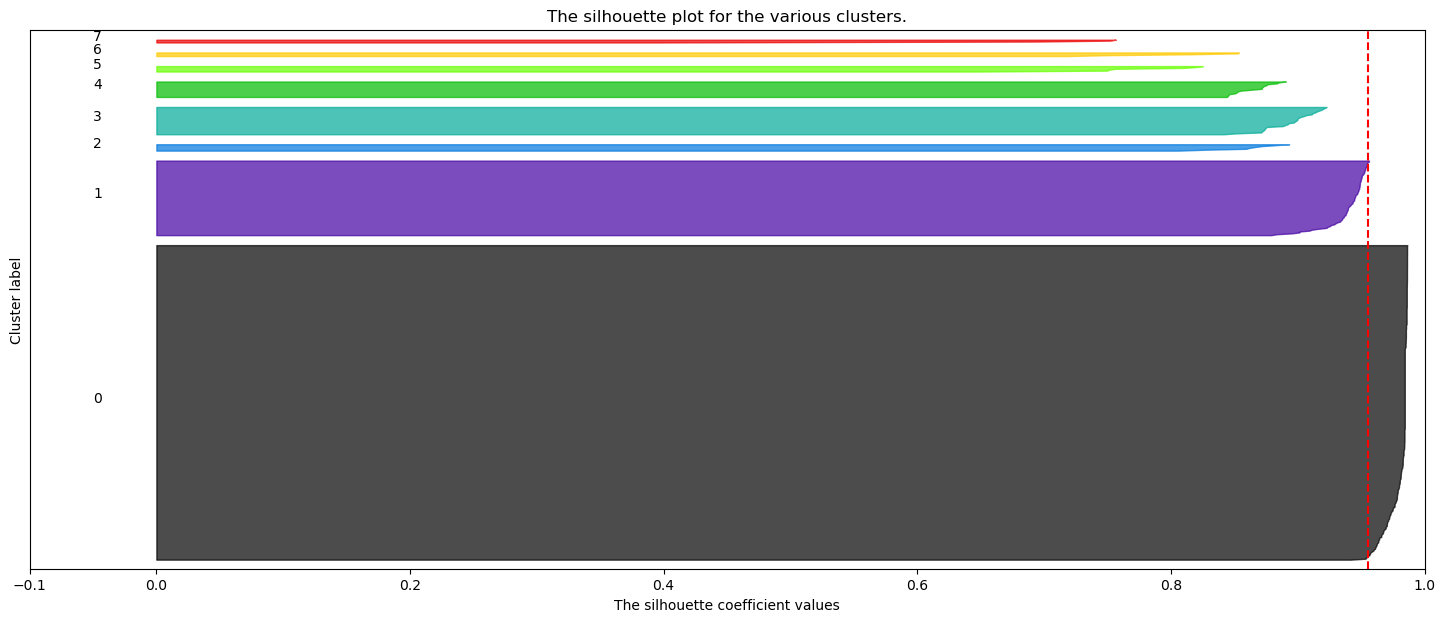

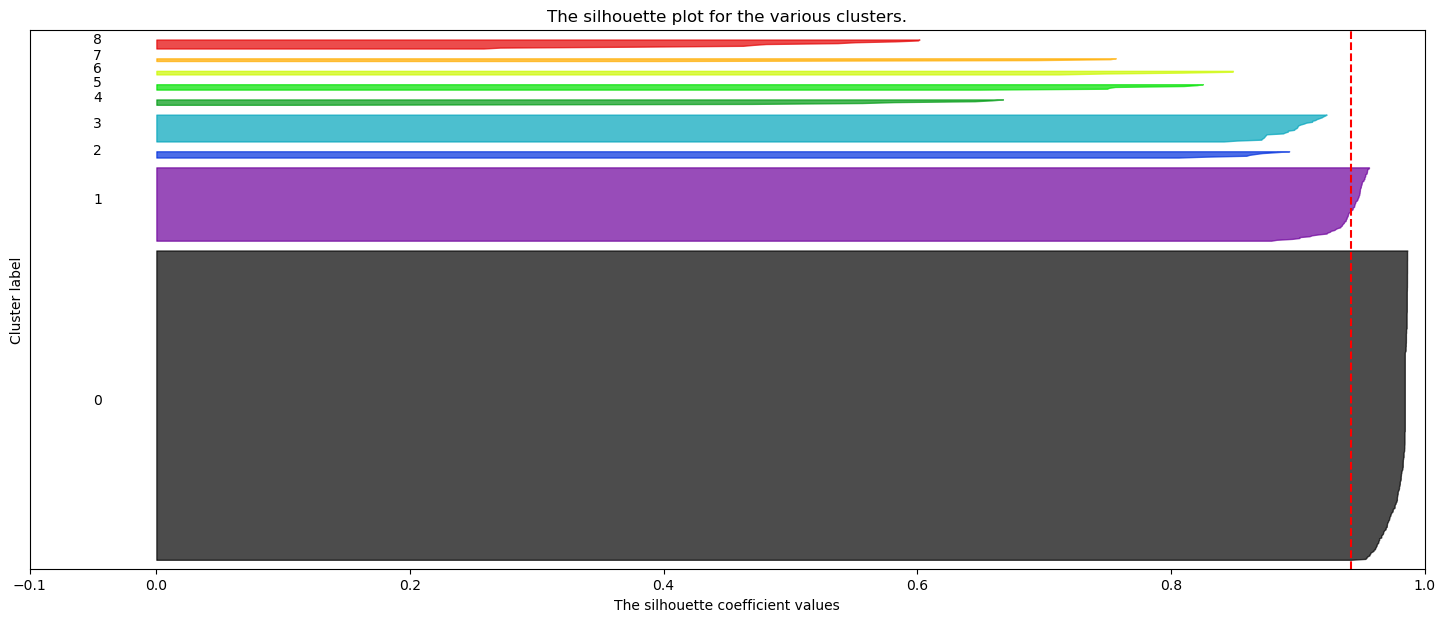

In [9]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Visualise Data

In [10]:
# K-Means
trace = go.Scatter3d(
                    x = df['na_sales'],
                    y = df['eu_sales'],
                    z = df['other_sales'],
                    mode = 'markers',
                    marker=dict(color=df['kmeans'], size=3, opacity=0.8)
)

data = [trace]
# Create a 3D scatter plot
layout = go.Layout(
                    title="K-Means",
                    scene= dict(
                                xaxis = dict(title= "NA Sales"),
                                yaxis = dict(title= "EU Sales"),
                                zaxis = dict(title= "Other Sales"))
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

# DBSCAN
trace = go.Scatter3d(
                    x = df['na_sales'],
                    y = df['eu_sales'],
                    z = df['other_sales'],
                    mode = 'markers',
                    marker=dict(color=df['dbscan'], size=3, opacity=0.8)
)

data = [trace]
# Create a 3D scatter plot
layout = go.Layout(
                    title="DBSCAN",
                    scene= dict(
                                xaxis = dict(title= "NA Sales"),
                                yaxis = dict(title= "EU Sales"),
                                zaxis = dict(title= "Other Sales"))
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()

# GMM
trace = go.Scatter3d(
                    x = df['na_sales'],
                    y = df['eu_sales'],
                    z = df['other_sales'],
                    mode = 'markers',
                    marker=dict(color=df['gmm'], size=3, opacity=0.8)
)

data = [trace]
# Create a 3D scatter plot
layout = go.Layout(
                    title="GMM",
                    scene= dict(
                                xaxis = dict(title= "NA Sales"),
                                yaxis = dict(title= "EU Sales"),
                                zaxis = dict(title= "Other Sales"))
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)
plt.show()


# Silhouette scores
kmeans_score = silhouette_score(df, df['kmeans'])
dbscan_score = silhouette_score(df, df['dbscan'])
gmm_score = silhouette_score(df, df['gmm'])

table_fields = ['Model', 'Score']

silhouette_table = PrettyTable(table_fields)
silhouette_table.padding_width = 1
silhouette_table.title = 'Silhouette Scores'
silhouette_table.add_row(['K-Means', kmeans_score])
silhouette_table.add_row(['DBSCAN', dbscan_score])
silhouette_table.add_row(['GMM', gmm_score])


print(silhouette_table)

+------------------------------+
|      Silhouette Scores       |
+---------+--------------------+
|  Model  |       Score        |
+---------+--------------------+
| K-Means | 0.9560859010764104 |
|  DBSCAN | 0.9335888339668728 |
|   GMM   | 0.9560859010764104 |
+---------+--------------------+


## Dimensionality Reduction: t-SNE & PCA

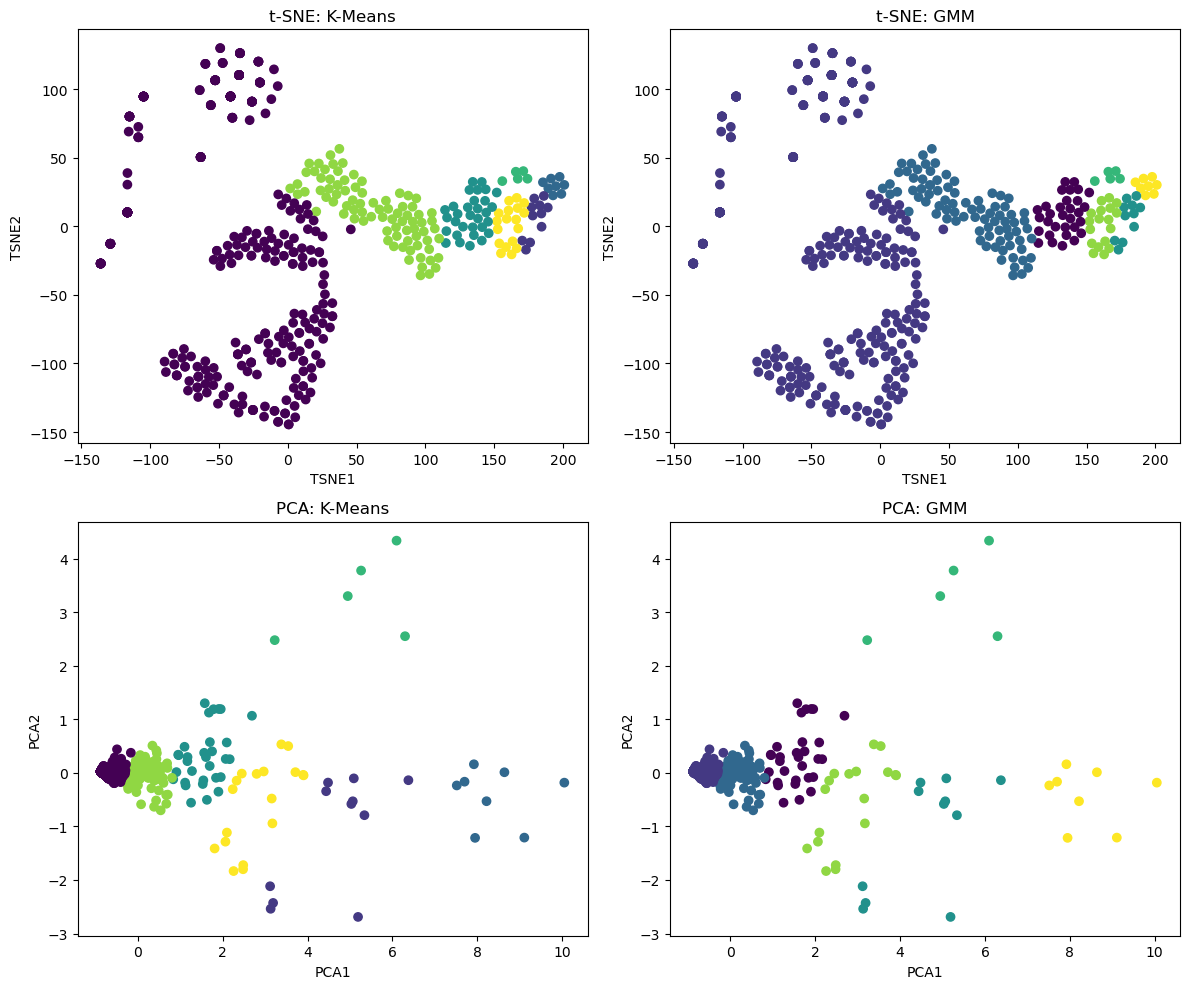

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale
X = df[['na_sales', 'eu_sales', 'other_sales']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['kmeans'] = df['kmeans']
tsne_df['dbscan'] = df['dbscan']
tsne_df['gmm'] = df['gmm']

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['kmeans'] = df['kmeans']
pca_df['dbscan'] = df['dbscan']
pca_df['gmm'] = df['gmm']

# Subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# -------------- t-SNE --------------
axs[0, 0].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=df['kmeans'])
axs[0, 0].set_title('t-SNE: K-Means')
axs[0, 0].set_xlabel('TSNE1')
axs[0, 0].set_ylabel('TSNE2')

axs[0, 1].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=df['gmm'])
axs[0, 1].set_title('t-SNE: GMM')
axs[0, 1].set_xlabel('TSNE1')
axs[0, 1].set_ylabel('TSNE2')

# -------------- PCA --------------
axs[1, 0].scatter(pca_df['PCA1'], pca_df['PCA2'], c=df['kmeans'])
axs[1, 0].set_title('PCA: K-Means')
axs[1, 0].set_xlabel('PCA1')
axs[1, 0].set_ylabel('PCA2')

axs[1, 1].scatter(pca_df['PCA1'], pca_df['PCA2'], c=df['gmm'])
axs[1, 1].set_title('PCA: GMM')
axs[1, 1].set_xlabel('PCA1')
axs[1, 1].set_ylabel('PCA2')

plt.tight_layout()
plt.savefig('dim_reduction_scatter.png')


# Classification

In [12]:
X = df.drop(columns=['kmeans', 'dbscan', 'gmm'])
y = df['gmm']

#### Split into train and test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Scale data

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Create models

In [15]:
rf = RandomForestClassifier(n_estimators=1000, max_features=3, random_state=42)
gb = GradientBoostingClassifier(n_estimators=1000, min_samples_split=10, 
                                criterion="squared_error", max_features=3, random_state=42)

#### Train & test models

In [16]:
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

## Visualise Accuracy

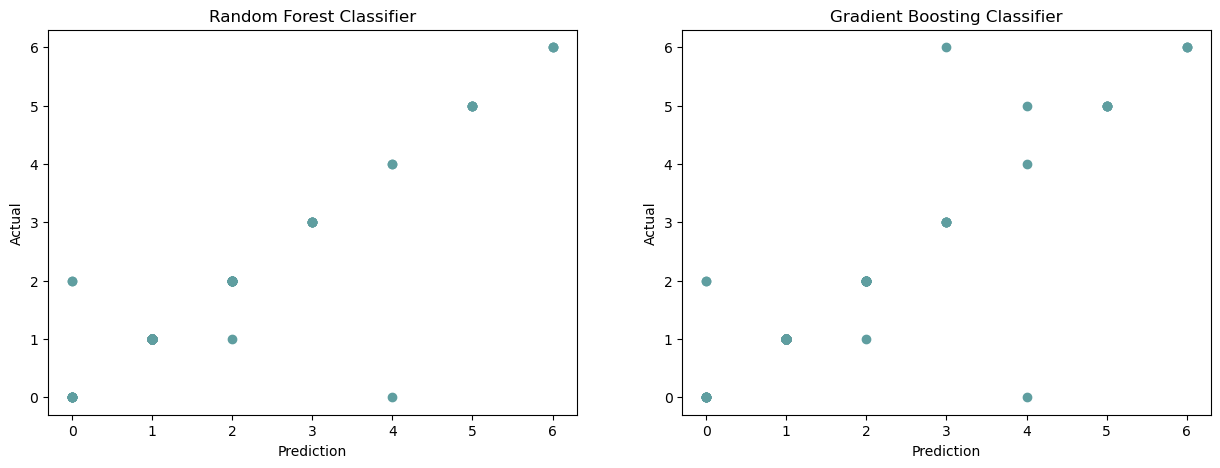

+-------------------+--------------------+----------------------+---------------------+---------------------+
|       Model       |         F1         |         MAE          |         MSE         |         RMSE        |
+-------------------+--------------------+----------------------+---------------------+---------------------+
|   Random Forest   | 0.9725790557478674 | 0.059602649006622516 | 0.16556291390728478 | 0.40689422938557973 |
| Gradient Boosting | 0.9571580529096461 | 0.08609271523178808  | 0.23178807947019867 | 0.48144374486558517 |
+-------------------+--------------------+----------------------+---------------------+---------------------+
0.17880794701986755


C:\Users\Joshc\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



In [17]:
# Create subplots with 2 row and 3 columns
plt.figure(figsize=(15, 5))

color="cadetblue"

# ------- Random Forest -------

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, color="cadetblue", label="Prediction Actual vs Prediction data")
plt.title("Random Forest Classifier")
plt.xlabel("Prediction")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gb, color="cadetblue", label="Prediction Actual vs Prediction data")
plt.title("Gradient Boosting Classifier")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

f1_rf = metrics.f1_score(y_test, y_pred_rf, average='weighted')
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf, squared=True)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

f1_gb = metrics.f1_score(y_test, y_pred_gb, average='weighted')
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb, squared=True)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)

table_fields = ['Model', 'F1', 'MAE', 'MSE', 'RMSE']
table = PrettyTable(table_fields)
table.padding_width=1
table.add_row(['Random Forest', f1_rf, mae_rf, mse_rf, rmse_rf])
table.add_row(['Gradient Boosting', f1_gb, mae_gb, mse_gb, rmse_gb])
print(table)
print(rf.score(X_test, y_pred_rf))

#### Confusion Matrix

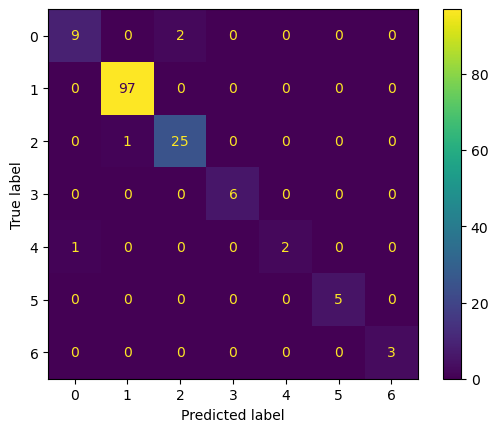

In [18]:
cm = ConfusionMatrixDisplay.from_estimator(rf, X_test_scaled, y_test)
cm.figure_.savefig('confusion_matrix.png')
plt.show()